# Equity Return Forecasting with Statistical and Machine Learning Models

## Project Overview
This project studies the predictability of daily equity returns using a combination of
classical time-series models and modern machine learning methods.

**Asset:** V 
**Sample period:** 2002-01-01 to 2024-12-31  
**Frequency:** Daily  
**Target variable:** Log returns  

The objective is not only to generate forecasts, but to evaluate:
- Whether linear models can adequately describe return dynamics
- Whether volatility clustering explains most of the dependence
- Whether machine learning models provide incremental predictive power

# Multi-Model Market Forecasting & Risk Engine

**Industrial-Grade Two-Step ARIMA-GARCH Implementation**

| Model | Type | Approach |
|-------|------|----------|
| **ARIMA-GARCH** | Econometric | Two-step: ARIMA (statsmodels) → GARCH on residuals |
| **XGBoost** | ML | Lagged features + walk-forward validation |
| **LSTM** | Deep Learning | Sequence-based RNN |

---

## Table of Contents

1. [Setup & Configuration](#setup)
2. [Data Ingestion](#data)
3. [Part A: ARIMA-GARCH](#arima)
4. [Part B: XGBoost](#xgboost)
5. [Part C: LSTM](#lstm)
6. [Part D: Consolidated Comparison](#comp)

<a id='setup'></a>
## 0. Setup & Configuration

In [ ]:
# === GLOBAL CONFIGURATION ===
TICKER = "AAPL"              # Asset to analyze
START_DATE = "2012-01-01"   # Training start
END_DATE = "2025-12-31"     # Training end 
TEST_SIZE = 126              # Out-of-sample test days (~6 months)
RANDOM_SEED = 42

# ARIMA Grid Search Constraints
MAX_AR = 4                  # Max AR order (p)
MAX_MA = 4                  # Max MA order (q)
MAX_D = 2                   # Max differencing order for ADF search

# GARCH Constraints
GARCH_P = 1
GARCH_Q = 1
DISTRIBUTIONS = ['normal', 't', 'skewt', 'ged']
# ============================

In [195]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import torch
torch.set_num_threads(1)
# torch.set_num_interop_threads(1)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

load_dotenv()
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

xgb_params = {"nthread": 1}

print("✓ All imports successful.")

#threads are capped to prevent oversubscription of CPU cores

✓ All imports successful.


<a id='data'></a>
## 1. Data and Preprocessing

Daily adjusted prices are downloaded and transformed into log returns.
Log returns are used because they are:
- Stationary in levels
- Scale-invariant
- Standard in empirical finance

All models are estimated using the same return series to ensure comparability.

In [196]:
def fetch_data_alpaca(ticker, start, end):
    try:
        from alpaca_trade_api import REST
        api_key = os.getenv('ALPACA_API_KEY')
        secret_key = os.getenv('ALPACA_SECRET_KEY')
        endpoint = os.getenv('ALPACA_ENDPOINT', 'https://paper-api.alpaca.markets')
        if not api_key or api_key == 'your_api_key_here':
            return None
        api = REST(api_key, secret_key, endpoint)
        bars = api.get_bars(ticker, '1Day', start=start, end=end, adjustment='all').df
        if bars.empty:
            return None
        bars = bars.reset_index()
        bars = bars.rename(columns={'timestamp': 'Date', 'close': 'Price'})
        bars = bars[['Date', 'Price']]
        bars['Date'] = pd.to_datetime(bars['Date']).dt.tz_localize(None)
        bars = bars.set_index('Date')
        print(f"✓ Data from Alpaca: {len(bars)} obs")
        return bars
    except:
        return None

def fetch_data_yfinance(ticker, start, end):
    import yfinance as yf
    raw = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    if raw.empty:
        raise ValueError(f"No data for {ticker}")
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw['Close'].to_frame()
        df.columns = ['Price']
    else:
        df = raw[['Close']].copy()
        df.columns = ['Price']
    df.index.name = 'Date'
    print(f"✓ Data from yfinance: {len(df)} obs")
    return df

def fetch_data(ticker, start, end):
    print(f"Fetching {ticker} from {start} to {end}...")
    df = fetch_data_alpaca(ticker, start, end)
    if df is None:
        df = fetch_data_yfinance(ticker, start, end)
    return df

In [197]:
df = fetch_data(TICKER, START_DATE, END_DATE)
df['Return'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

print(f"\n✓ Dataset: {len(df)} observations")
print(f"  Range: {df.index[0].date()} to {df.index[-1].date()}")
df.head()

Fetching ASML from 2012-01-01 to 2025-12-31...
✓ Data from Alpaca: 2514 obs

✓ Dataset: 2513 observations
  Range: 2016-01-05 to 2025-12-31


,Price,Return
Date,,
2016-01-05 05:00:00,79.32,-0.010160
2016-01-06 05:00:00,77.66,-0.021150
2016-01-07 05:00:00,75.71,-0.025430
2016-01-08 05:00:00,73.68,-0.027179
2016-01-11 05:00:00,75.55,0.025063


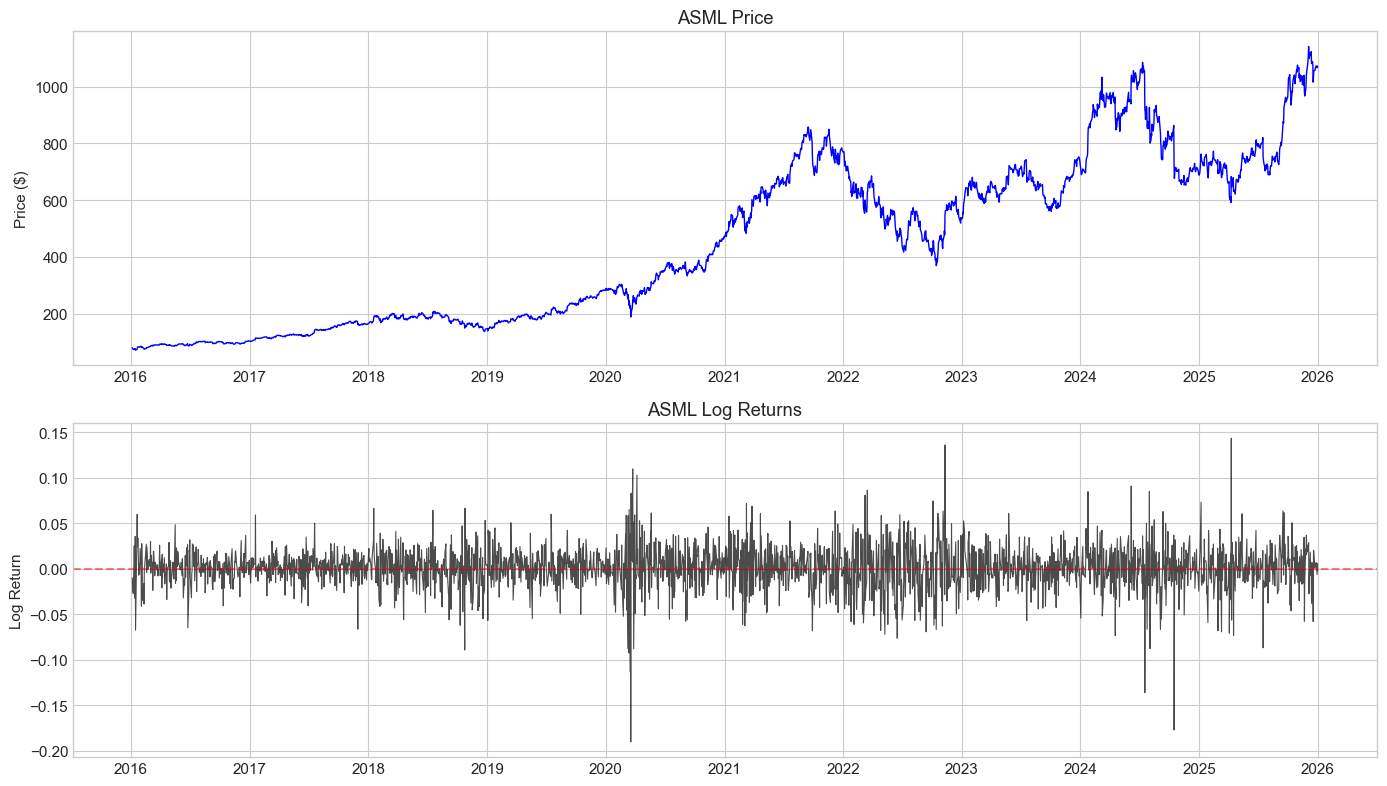

In [198]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df.index, df['Price'], 'b-', lw=1)
axes[0].set_title(f'{TICKER} Price')
axes[0].set_ylabel('Price ($)')
axes[1].plot(df.index, df['Return'], 'k-', alpha=0.7, lw=0.8)
axes[1].axhline(0, color='red', ls='--', alpha=0.5)
axes[1].set_title(f'{TICKER} Log Returns')
axes[1].set_ylabel('Log Return')
plt.tight_layout()
plt.show()

<a id='arima'></a>
---

# Part A: ARIMA-GARCH (Two-Step Estimation)

**Methodology:**
1. **Step 1**: Determine `d` via ADF test (iterative)
2. **Step 2**: Grid search ARIMA(p,d,q) using statsmodels → select by AIC
3. **Step 3**: Fit GARCH(1,1) on ARIMA residuals → select distribution by AIC
4. **Step 4**: Diagnostics (Ljung-Box, ARCH-LM)
5. **Step 5**: Walk-forward backtest

### A.1: Stationarity Test & Optimal Differencing Order

In [199]:
def adf_test(series, name='Series', alpha=0.05):
    """Run ADF test and return (is_stationary, p_value, statistic)."""
    s = pd.Series(series).dropna()
    result = adfuller(s, autolag='AIC')
    stat, pval = result[0], result[1]
    print(f"ADF Test: {name}")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {pval:.4f}")
    print(f"  Stationary: {'Yes ✓' if pval < alpha else 'No ✗'}")
    return pval < alpha, pval, stat

def find_best_d_by_adf(series, base_name="Series", max_d=3, alpha=0.05):
    """
    Iteratively difference until ADF indicates stationarity.
    Returns (best_d, stationary_series, history).
    """
    s = pd.Series(series).dropna()
    history = []

    print("=" * 50)
    for d in range(0, max_d + 1):
        name = f"{base_name} (d={d})"
        is_stat, pval, stat = adf_test(s, name=name, alpha=alpha)
        history.append({"d": d, "p_value": pval, "stat": stat, "nobs": len(s)})
        print("-" * 50)

        if is_stat:
            print(f"\n✓ Stationary at d={d} (p={pval:.4f}).")
            print("=" * 50)
            return d, s, history

        if d < max_d:
            s = s.diff().dropna()

    print(f"\n⚠ Not stationary up to d={max_d}.")
    print("=" * 50)
    return None, s, history

In [200]:
# Test both Raw Price and Log Returns
print("\n" + "#" * 60)
print("# TESTING RAW PRICE")
print("#" * 60)
d_price, stationary_price, hist_price = find_best_d_by_adf(
    df['Price'], base_name="Raw Price", max_d=MAX_D
)

print("\n" + "#" * 60)
print("# TESTING LOG RETURNS")
print("#" * 60)
d_returns, stationary_returns, hist_returns = find_best_d_by_adf(
    df['Return'], base_name="Log Returns", max_d=MAX_D
)


############################################################
# TESTING RAW PRICE
############################################################
ADF Test: Raw Price (d=0)
  Statistic: -0.2743
  p-value:   0.9291
  Stationary: No ✗
--------------------------------------------------
ADF Test: Raw Price (d=1)
  Statistic: -14.1932
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=1 (p=0.0000).

############################################################
# TESTING LOG RETURNS
############################################################
ADF Test: Log Returns (d=0)
  Statistic: -14.8622
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=0 (p=0.0000).


In [201]:
# Decision: Which series to use for modelling
print("\n" + "=" * 60)
print("SERIES SELECTION FOR MODELLING")
print("=" * 60)

print(f"\nOption 1: Raw Price → requires d={d_price} differencing")
print(f"Option 2: Log Returns → requires d={d_returns} differencing")

# Prefer log returns if stationary at d=0 (no info loss from differencing)
if d_returns == 0:
    USE_SERIES = 'log_returns'
    SERIES_D = 0
    modelling_series = df['Return'].dropna()
    print(f"\n✓ SELECTED: Log Returns (d=0) - already stationary, no data loss")
elif d_price is not None:
    USE_SERIES = 'price'
    SERIES_D = d_price
    modelling_series = stationary_price
    print(f"\n✓ SELECTED: Differenced Price (d={d_price})")
else:
    USE_SERIES = 'log_returns'
    SERIES_D = d_returns if d_returns else 0
    modelling_series = stationary_returns
    print(f"\n✓ SELECTED: Log Returns (d={SERIES_D})")

print(f"\nModelling series length: {len(modelling_series)}")


SERIES SELECTION FOR MODELLING

Option 1: Raw Price → requires d=1 differencing
Option 2: Log Returns → requires d=0 differencing

✓ SELECTED: Log Returns (d=0) - already stationary, no data loss

Modelling series length: 2513


### A.2: ARIMA(p,d,q) Grid Search (Step 1 of Two-Step)

#### Mean Dynamics: ARIMA Modelling

ARIMA models are used to capture linear dependence in returns.
Model selection is performed via grid search over (p, d, q) using AIC and BIC.

Important assumptions:
- Finite memory
- Linear dynamics
- Single regime

These assumptions are tested empirically rather than taken for granted.

Using `statsmodels.tsa.arima.model.ARIMA` for the mean equation.

In [202]:
def fit_arima(series, order):
    """Fit ARIMA(p,d,q) and return (fit_result, AIC) or (None, inf) on failure."""
    try:
        model = ARIMA(series, order=order, trend="n") 
        fit = model.fit()
        return fit, fit.aic
    except:
        return None, np.inf

In [203]:
# Grid Search over ARIMA(p, d, q)
# Note: d is fixed from ADF test, but we include d=0 since we're using log returns
arima_results = []

print(f"ARIMA Grid Search: p ∈ [0,{MAX_AR}], d={SERIES_D}, q ∈ [0,{MAX_MA}]")
print("-" * 60)

for p in range(0, MAX_AR + 1):
    for q in range(0, MAX_MA + 1):
        order = (p, SERIES_D, q)
        fit, aic = fit_arima(modelling_series, order)
        if fit is not None:
            arima_results.append({
                'p': p, 'd': SERIES_D, 'q': q,
                'AIC': aic, 'BIC': fit.bic,
                'fit': fit
            })
            print(f"  ARIMA({p},{SERIES_D},{q}): AIC = {aic:.2f}, BIC = {fit.bic:.2f}")

arima_df = pd.DataFrame(arima_results).sort_values('AIC').reset_index(drop=True)

ARIMA Grid Search: p ∈ [0,4], d=0, q ∈ [0,4]
------------------------------------------------------------
  ARIMA(0,0,0): AIC = -11645.65, BIC = -11639.82
  ARIMA(0,0,1): AIC = -11658.94, BIC = -11647.28
  ARIMA(0,0,2): AIC = -11664.20, BIC = -11646.71
  ARIMA(0,0,3): AIC = -11666.36, BIC = -11643.04
  ARIMA(0,0,4): AIC = -11665.29, BIC = -11636.14
  ARIMA(1,0,0): AIC = -11660.56, BIC = -11648.90
  ARIMA(1,0,1): AIC = -11664.37, BIC = -11646.88
  ARIMA(1,0,2): AIC = -11664.26, BIC = -11640.94
  ARIMA(1,0,3): AIC = -11665.68, BIC = -11636.54
  ARIMA(1,0,4): AIC = -11669.47, BIC = -11634.49
  ARIMA(2,0,0): AIC = -11665.28, BIC = -11647.79
  ARIMA(2,0,1): AIC = -11664.06, BIC = -11640.74
  ARIMA(2,0,2): AIC = -11661.17, BIC = -11632.03
  ARIMA(2,0,3): AIC = -11651.16, BIC = -11616.18
  ARIMA(2,0,4): AIC = -11666.09, BIC = -11625.29
  ARIMA(3,0,0): AIC = -11665.26, BIC = -11641.94
  ARIMA(3,0,1): AIC = -11663.42, BIC = -11634.28
  ARIMA(3,0,2): AIC = -11662.08, BIC = -11627.11
  ARIMA(3,0,

In [204]:
# Select Best ARIMA
best_arima_row = arima_df.iloc[0]
BEST_P = int(best_arima_row['p'])
BEST_D = int(best_arima_row['d'])
BEST_Q = int(best_arima_row['q'])
best_arima_fit = best_arima_row['fit']

print(f"\n✓ BEST ARIMA: ARIMA({BEST_P},{BEST_D},{BEST_Q})")
print(f"  AIC: {best_arima_row['AIC']:.2f}")
print(f"  BIC: {best_arima_row['BIC']:.2f}")

print(len(arima_df))
print(arima_df.nsmallest(10, "AIC")[["p","d","q","AIC","BIC"]])


✓ BEST ARIMA: ARIMA(4,0,4)
  AIC: -11688.45
  BIC: -11635.98
25
   p  d  q           AIC           BIC
0  4  0  4 -11688.447795 -11635.984702
1  3  0  4 -11673.765388 -11627.131528
2  1  0  4 -11669.470306 -11634.494910
3  0  0  3 -11666.359382 -11643.042452
4  2  0  4 -11666.091435 -11625.286807
5  4  0  0 -11666.088709 -11636.942546
6  1  0  3 -11665.682540 -11636.536378
7  0  0  4 -11665.290345 -11636.144182
8  2  0  0 -11665.278448 -11647.790750
9  3  0  0 -11665.258397 -11641.941466


In [205]:
print(best_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 2513
Model:                 ARIMA(4, 0, 4)   Log Likelihood                5853.224
Date:                Thu, 22 Jan 2026   AIC                         -11688.448
Time:                        16:11:13   BIC                         -11635.985
Sample:                             0   HQIC                        -11669.406
                               - 2513                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8082      0.565     -1.430      0.153      -1.916       0.300
ar.L2          0.3768      0.679      0.555      0.579      -0.954       1.707
ar.L3          0.1580      0.758      0.209      0.8

### A.3: GARCH on ARIMA Residuals (Step 2 of Two-Step)

#### Volatility Dynamics: GARCH Modelling

Financial returns exhibit strong conditional heteroskedasticity.
After fitting the ARIMA model, residuals are tested for ARCH effects.

GARCH models are then fitted to:
- Remove variance dependence
- Capture volatility clustering
- Improve distributional assumptions via non-Gaussian innovations

Extract residuals from ARIMA, then fit GARCH(1,1) with different distributions.

In [206]:
# Extract ARIMA residuals
arima_resid = best_arima_fit.resid.dropna()

# Scale for GARCH numerical stability
arima_resid_scaled = arima_resid * 100

print(f"ARIMA residuals: {len(arima_resid)} observations")
print(f"Residual mean: {arima_resid.mean():.6f}")
print(f"Residual std:  {arima_resid.std():.6f}")

ARIMA residuals: 2513 observations
Residual mean: 0.001099
Residual std:  0.023541


In [207]:
# Test for ARCH effects in residuals
arch_test = het_arch(arima_resid_scaled, nlags=5)
print("ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)")
print(f"  LM Statistic: {arch_test[0]:.4f}")
print(f"  p-value:      {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("\n✓ ARCH effects detected → GARCH modelling is justified.")
else:
    print("\n⚠ No significant ARCH effects. GARCH may not add value.")

ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)
  LM Statistic: 159.1925
  p-value:      0.0000

✓ ARCH effects detected → GARCH modelling is justified.


In [208]:
garch_results = []
for dist in DISTRIBUTIONS:
    for lags in [0, 1, 2]:
        mean_type = "Zero" if lags == 0 else "AR"
        try:
            am = arch_model(
                arima_resid_scaled,
                mean=mean_type,
                lags=lags if lags > 0 else None,
                vol="Garch",
                p=1, q=1,
                dist=dist,
                rescale=False
            )
            fit = am.fit(disp="off", show_warning=False)
            garch_results.append({"Dist": dist, 
                                  "lags": lags, 
                                  "AIC": fit.aic, 
                                  "BIC": fit.bic,
                                  "LogLik": fit.loglikelihood, 
                                  "fit": fit})
        except:
            pass

garch_df = pd.DataFrame(garch_results).sort_values("AIC").reset_index(drop=True)
best_garch_fit = garch_df.iloc[0]["fit"]

print("\n" + "=" * 50)
print("GARCH Distribution Ranking:")
print(garch_df[['Dist', 'lags', 'AIC', 'BIC']])

std_resid = best_garch_fit.std_resid.dropna()
print(acorr_ljungbox(std_resid, lags=[5,10,15,20], return_df=True))
print(acorr_ljungbox(std_resid**2, lags=[5,10,15,20], return_df=True))


GARCH Distribution Ranking:
      Dist  lags           AIC           BIC
0    skewt     2  10886.231615  10932.859106
1    skewt     1  10890.521512  10931.323353
2        t     2  10895.399353  10936.198408
3        t     1  10899.177651  10934.150658
4    skewt     0  10903.967778  10933.113941
5      ged     2  10917.354064  10958.153118
6      ged     1  10920.923683  10955.896690
7        t     0  10926.709368  10950.026298
8      ged     0  10947.909346  10971.226276
9   normal     2  11099.592136  11134.562754
10  normal     1  11102.359715  11131.503888
11  normal     0  11114.171237  11131.658934
      lb_stat  lb_pvalue
5    2.492384   0.777642
10   5.085268   0.885410
15  16.895454   0.325153
20  23.360147   0.271458
      lb_stat  lb_pvalue
5    4.603655   0.466136
10  10.820017   0.371711
15  15.245335   0.433894
20  17.525875   0.618610


In [209]:
# Select Best GARCH
best_garch_row = garch_df.iloc[0]
BEST_DIST = best_garch_row['Dist']
best_garch_fit = best_garch_row['fit']

print(f"\n✓ BEST GARCH: GARCH({GARCH_P},{GARCH_Q}) with {BEST_DIST} innovations")
print(f"\n✓ FULL MODEL: ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH({GARCH_P},{GARCH_Q})-{BEST_DIST}")




✓ BEST GARCH: GARCH(1,1) with skewt innovations

✓ FULL MODEL: ARIMA(4,0,4)-GARCH(1,1)-skewt


In [210]:
print(best_garch_fit.summary())

                                 AR - GARCH Model Results                                
Dep. Variable:                              None   R-squared:                      -0.001
Mean Model:                                   AR   Adj. R-squared:                 -0.002
Vol Model:                                 GARCH   Log-Likelihood:               -5435.12
Distribution:      Standardized Skew Student's t   AIC:                           10886.2
Method:                       Maximum Likelihood   BIC:                           10932.9
                                                   No. Observations:                 2511
Date:                           Thu, Jan 22 2026   Df Residuals:                     2508
Time:                                   16:11:14   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

### A.4: Residual Diagnostics

In [211]:
# Standardized residuals from GARCH
std_resid = best_garch_fit.std_resid.dropna()

# Ljung-Box Test
lb_test = acorr_ljungbox(std_resid, lags=[5, 10, 15, 20], return_df=True)
print("Ljung-Box Test (H0: No autocorrelation)")
print(lb_test)

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠ Some lags show autocorrelation.")
else:
    print("\n✓ No significant autocorrelation in standardized residuals.")

Ljung-Box Test (H0: No autocorrelation)
      lb_stat  lb_pvalue
5    2.492384   0.777642
10   5.085268   0.885410
15  16.895454   0.325153
20  23.360147   0.271458

✓ No significant autocorrelation in standardized residuals.


### Why Residual Autocorrelation Persists Sometimes (Not a Modelling Error)

**1. ARIMA is an approximation, not reality** 


ARIMA assumes finite memory, linear dynamics, and a single regime. Residual autocorrelation means not all dependence is linear / stationary/ finite-memory.

Equity markets violate all three. Even if ARIMA(3,0,4) is optimal within the ARIMA class, the class itself is misspecified relative to real market dynamics.


**2. GARCH removes variance dependence, not all dependence**  


GARCH ensures conditional variance is correctly modelled, not that residuals are fully independent.  
As a result:
- Squared standardised residuals are typically iid ✔  
- Raw standardised residuals may retain mild dependence ✖  
This behaviour is expected and normal.


**3. Large samples make Ljung–Box very sensitive**  


With long samples (e.g. >2000 observations), Ljung–Box detects even tiny, economically irrelevant correlations.  
Rejections at higher lags reflect statistical power, not model failure.

**Conclusion**  


Residual autocorrelation in this context arises from **market structure and model assumptions**, not from implementation errors.

In [212]:
# ARCH-LM Test on GARCH standardized residuals
arch_lm = het_arch(std_resid, nlags=5)
print("\nARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)")
print(f"  LM Statistic: {arch_lm[0]:.4f}")
print(f"  p-value:      {arch_lm[1]:.4f}")

if arch_lm[1] > 0.05:
    print("\n✓ No remaining ARCH effects. Variance model is adequate.")
else:
    print("\n⚠ Remaining ARCH effects. Consider higher GARCH order.")


ARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)
  LM Statistic: 4.5860
  p-value:      0.4685

✓ No remaining ARCH effects. Variance model is adequate.


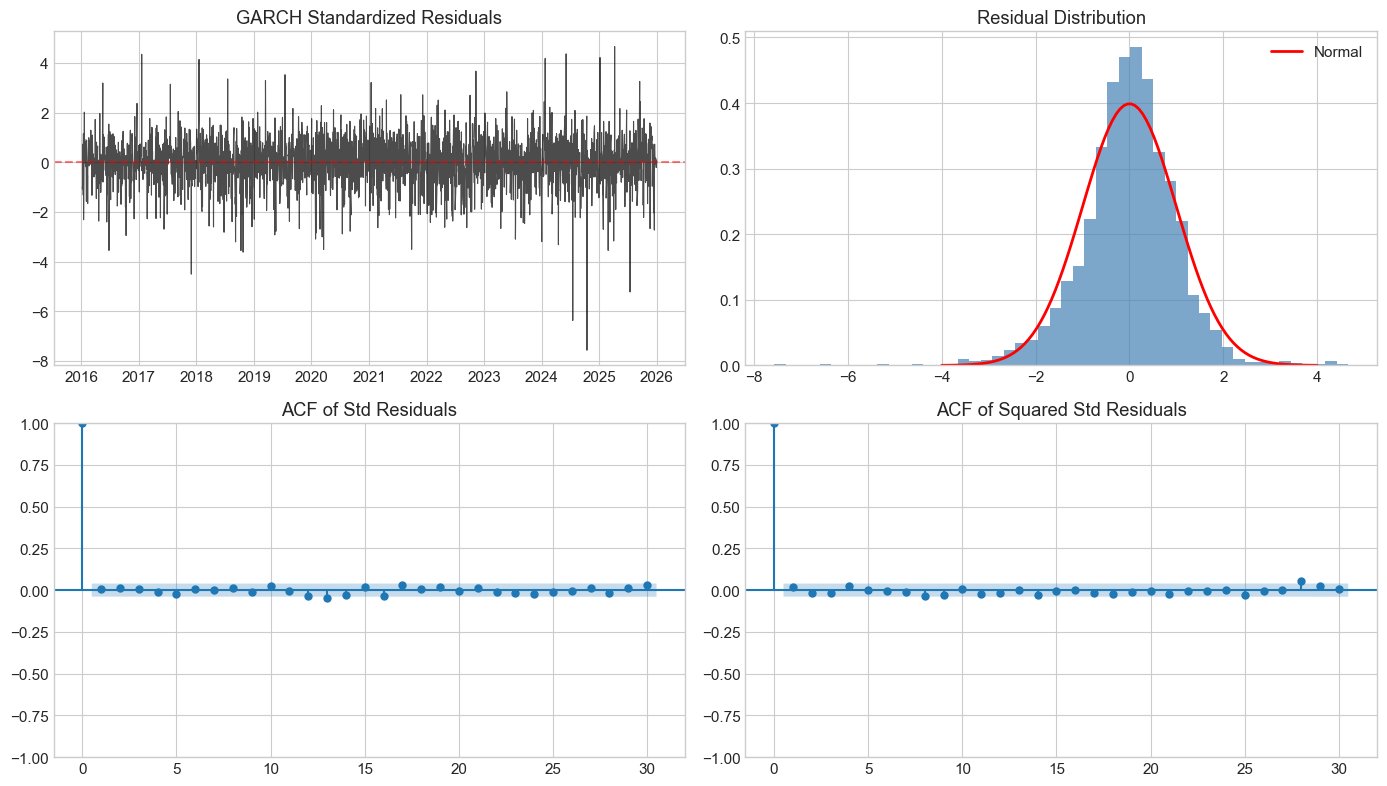

In [213]:
# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(std_resid.index, std_resid.values, 'k-', alpha=0.7, lw=0.8)
axes[0, 0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0, 0].set_title('GARCH Standardized Residuals')

axes[0, 1].hist(std_resid, bins=50, density=True, alpha=0.7, color='steelblue')
x = np.linspace(-4, 4, 100)
axes[0, 1].plot(x, stats.norm.pdf(x), 'r-', lw=2, label='Normal')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].legend()

plot_acf(std_resid, lags=30, ax=axes[1, 0], title='ACF of Std Residuals')
plot_acf(std_resid**2, lags=30, ax=axes[1, 1], title='ACF of Squared Std Residuals')

plt.tight_layout()
plt.show()

### A.5: In-Sample Volatility Bands

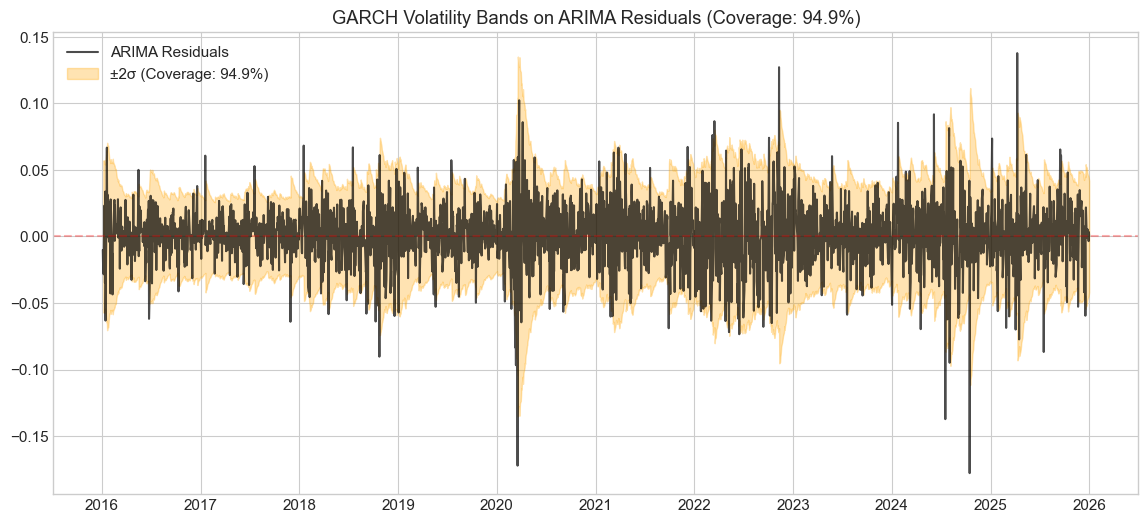

In [214]:
cond_vol = best_garch_fit.conditional_volatility / 100  # Unscale
aligned_resid = arima_resid.iloc[-len(cond_vol):]

inside = (aligned_resid.values > -2*cond_vol.values) & (aligned_resid.values < 2*cond_vol.values)
coverage = inside.mean()

plt.figure(figsize=(14, 6))
plt.plot(aligned_resid.index, aligned_resid.values, 'k-', alpha=0.7, label='ARIMA Residuals')
plt.fill_between(aligned_resid.index, -2*cond_vol.values, 2*cond_vol.values, 
                 alpha=0.3, color='orange', label=f'±2σ (Coverage: {coverage:.1%})')
plt.axhline(0, color='red', ls='--', alpha=0.3)
plt.title(f'GARCH Volatility Bands on ARIMA Residuals (Coverage: {coverage:.1%})')
plt.legend()
plt.show()

### A.6: Walk-Forward Backtest (Two-Step)

In [215]:
series = modelling_series
train_end = len(series) - TEST_SIZE

arima_garch_forecasts, arima_garch_sigmas, actuals, dates = [], [], [], []
fail_count = 0

last_fc = np.nan
last_sigma = np.nan

for i in tqdm(range(TEST_SIZE), desc="ARIMA-GARCH Backtest"):
    train = series.iloc[:train_end + i]
    actual = series.iloc[train_end + i]
    date = series.index[train_end + i]

    try:
        # 1) Mean model (ensure trend matches your selection)
        arima_fit = ARIMA(train, order=(BEST_P, BEST_D, BEST_Q), trend="n").fit()
        arima_fc = float(arima_fit.forecast(steps=1).iloc[0])

        resid = arima_fit.resid.dropna()

        # 2) Vol model on residuals (no manual *100 scaling)
        am = arch_model(
            resid,
            mean="AR",
            lags=1,
            vol="Garch",
            p=GARCH_P,
            q=GARCH_Q,
            dist=BEST_DIST
        )
        gfit = am.fit(disp="off", show_warning=False)

        fcast = gfit.forecast(horizon=1, reindex=False)
        var1 = float(fcast.variance.values[-1, 0])
        vol_fc = float(np.sqrt(var1))

        last_fc, last_sigma = arima_fc, vol_fc

    except Exception:
        fail_count += 1
        # carry-forward
        arima_fc = last_fc
        vol_fc = last_sigma

    arima_garch_forecasts.append(arima_fc)
    arima_garch_sigmas.append(vol_fc)
    actuals.append(actual)
    dates.append(date)

print(f"Backtest finished. Failures handled: {fail_count}")

ARIMA-GARCH Backtest:   0%|          | 0/126 [00:00<?, ?it/s]

Backtest finished. Failures handled: 0


In [216]:
arima_results = pd.DataFrame({
    'Date': dates,
    'Actual': actuals,
    'ARIMA_GARCH_Pred': arima_garch_forecasts,
    'ARIMA_GARCH_Sigma': arima_garch_sigmas
}).set_index('Date')

ag_mse = mean_squared_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_mae = mean_absolute_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_dir = np.mean(np.sign(arima_results['Actual']) == np.sign(arima_results['ARIMA_GARCH_Pred']))

print(f"\n=== ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST} Backtest ===")
print(f"MSE:           {ag_mse:.8f}")
print(f"MAE:           {ag_mae:.8f}")
print(f"Direction Acc: {ag_dir:.2%}")


=== ARIMA(4,0,4)-GARCH(1,1)-skewt Backtest ===
MSE:           0.00050243
MAE:           0.01718946
Direction Acc: 56.35%


In [217]:
mu = np.array(arima_garch_forecasts)
sigma = np.array(arima_garch_sigmas)
y = np.array(actuals)

eps = 1e-12
z = mu / (sigma + eps)

def backtest_threshold(z, y, c, cost=0.0):
    # positions: +1 (Long), -1 (Short), 0 (Flat)
    pos = np.where(z > c, 1, np.where(z < -c, -1, 0))

    strat = pos * y
    turnover = np.abs(np.diff(pos, prepend=0))
    strat_net = strat - cost * turnover

    traded = pos != 0
    dir_acc = np.mean(strat[traded] > 0) if traded.any() else np.nan
    freq = traded.mean()

    return {
        "threshold_c": c,
        "trade_freq": freq,
        "dir_acc_traded": dir_acc,
        "mean_return": strat_net.mean(),
        "volatility": strat_net.std(ddof=1),
        "sharpe": (strat_net.mean() / (strat_net.std(ddof=1) + eps)) * np.sqrt(252),
        "positions": pos
    }



### Threshold Sweep Table and choosing of best threshold 


In [218]:
# --- What it does:
# Runs a threshold sweep, prints a clean metrics table, and selects the best quantile/threshold by Sharpe.

quantiles = [0.60, 0.70, 0.80, 0.90]
results = []

for q in quantiles:
    c = np.quantile(np.abs(z), q)
    res = backtest_threshold(z, y, c, cost=0.0001)
    res["quantile"] = q
    results.append(res)

results_df = pd.DataFrame(results)[
    ["quantile", "threshold_c", "trade_freq", "dir_acc_traded",
     "mean_return", "volatility", "sharpe"]
].sort_values("sharpe", ascending=False)

print("\n=== Threshold Sweep (sorted by Sharpe) ===")
print(results_df.round(4).to_string(index=False))

best_row = results_df.iloc[0]
q_star = float(best_row["quantile"])
c_star = float(best_row["threshold_c"])

print(f"\nSelected threshold: quantile={q_star:.2f}, c={c_star:.4f} (best Sharpe)")


=== Threshold Sweep (sorted by Sharpe) ===
 quantile  threshold_c  trade_freq  dir_acc_traded  mean_return  volatility  sharpe
      0.6       0.0027      0.3968          0.5800       0.0016      0.0140  1.8544
      0.9       0.0350      0.1032          0.6154       0.0005      0.0066  1.2965
      0.8       0.0148      0.1984          0.5200       0.0005      0.0092  0.8925
      0.7       0.0079      0.3016          0.5000       0.0004      0.0128  0.5147

Selected threshold: quantile=0.60, c=0.0027 (best Sharpe)


### Next-day action

In [219]:
# --- What it does:
# Creates an action table where today's signal determines NEXT day’s position (no look-ahead),
# and also prints a trades-only subset (non-FLAT days).

pos_raw = np.where(z > c_star, 1, np.where(z < -c_star, -1, 0))

# IMPORTANT: shift by 1 so the decision at time t is applied to return at time t+1
pos_next_day = pd.Series(pos_raw).shift(1).fillna(0).astype(int).to_numpy()

action_map = {1: "LONG", -1: "SHORT", 0: "FLAT"}
actions = pd.Series(pos_next_day).map(action_map)

actions_df = pd.DataFrame({
    "mu_hat": mu,
    "sigma_hat": sigma,
    "z_score": z,
    "position_next_day": pos_next_day,
    "action_next_day": actions,
    "actual_return": y
})

print("\n=== Action Table (next-day aligned) ===")
print(actions_df.head(10).round(4).to_string(index=False))

trades_only_df = actions_df[actions_df["position_next_day"] != 0].copy()
print("\n=== Trades Only (non-FLAT) ===")
print(trades_only_df.head(10).round(4).to_string(index=False))
print(f"\nTrade frequency (realised): {np.mean(pos_next_day != 0):.4f}")


=== Action Table (next-day aligned) ===
 mu_hat    sigma_hat  z_score  position_next_day action_next_day  actual_return
-0.0024 2.005914e+08  -0.0000                  0            FLAT        -0.0064
 0.0014 3.875910e+05   0.0000                  0            FLAT        -0.0119
 0.0007 6.240000e-02   0.0114                  0            FLAT         0.0114
-0.0023 8.750000e-02  -0.0263                  1            LONG         0.0072
 0.0022 4.027700e+00   0.0006                 -1           SHORT         0.0028
-0.0026 2.280630e+02  -0.0000                  0            FLAT        -0.0002
 0.0021 4.418739e+03   0.0000                  0            FLAT         0.0060
-0.0024 1.982000e-01  -0.0119                  0            FLAT         0.0200
 0.0004 1.132624e+03   0.0000                 -1           SHORT        -0.0870
 0.0062 1.219010e+01   0.0005                  0            FLAT        -0.0127

=== Trades Only (non-FLAT) ===
 mu_hat   sigma_hat  z_score  position_next_day

## Combined confidence + vol-targeted sizing + performance table

In [220]:
# --- What it does:
# Converts mu/sigma into a continuous position size using BOTH:
# (i) confidence (z-score) and (ii) volatility targeting, with leverage caps and costs.
# Outputs summary metrics.

def size_confidence_vol_target(mu, sigma, sigma_target=0.01, c=0.5, k=1.0, w_max=2.0):
    """
    w_t = clip( (sigma_target / sigma_t) * f(z_t), -w_max, w_max )
    with f(z) = 0 if |z|<=c else k*(|z|-c)*sign(z)
    """
    eps = 1e-12
    z = mu / (sigma + eps)

    f = np.zeros_like(z)
    mask = np.abs(z) > c
    f[mask] = k * (np.abs(z[mask]) - c) * np.sign(z[mask])

    w = (sigma_target / (sigma + eps)) * f
    return np.clip(w, -w_max, w_max)

# Example hyperparams (tune these on VALIDATION only)
sigma_target = 0.01   # target daily vol (1%)
k = 1.0               # confidence scaling
w_max = 2.0           # leverage cap

w_raw = size_confidence_vol_target(mu, sigma, sigma_target=sigma_target, c=c_star, k=k, w_max=w_max)

# Next-day alignment (apply position decided at t to return at t+1)
w = pd.Series(w_raw).shift(1).fillna(0).to_numpy()

cost = 0.0001  # per unit turnover cost
turnover = np.abs(np.diff(w, prepend=0))
pnl_gross = w * y
pnl_net = pnl_gross - cost * turnover

ann_sharpe = (pnl_net.mean() / (pnl_net.std(ddof=1) + 1e-12)) * np.sqrt(252)

summary = pd.DataFrame([{
    "sigma_target": sigma_target,
    "threshold_c": c_star,
    "k": k,
    "w_max": w_max,
    "trade_freq_nonzero": float(np.mean(np.abs(w) > 0)),
    "mean_return": float(pnl_net.mean()),
    "volatility": float(pnl_net.std(ddof=1)),
    "sharpe": float(ann_sharpe),
}])

print("\n=== Confidence + Vol-Targeted Strategy Summary ===")
print(summary.round(6).to_string(index=False))


=== Confidence + Vol-Targeted Strategy Summary ===
 sigma_target  threshold_c   k  w_max  trade_freq_nonzero  mean_return  volatility  sharpe
         0.01     0.002697 1.0    2.0            0.396825      0.00001    0.000148 1.08046


---
# Machine Learning Models

Tree-based and neural network models are used to test whether
nonlinear patterns improve out-of-sample performance.

Key characteristics:
- Expanding-window training
- One-step-ahead forecasts
- Strict separation between training and test data

These models are evaluated against classical benchmarks rather than in isolation.

<a id='xgboost'></a>
---
# Part B: XGBoost

In [221]:
N_LAGS = 5
VOL_WINDOW = 21

feature_df = df[['Return']].copy()
for lag in range(1, N_LAGS + 1):
    feature_df[f'lag_{lag}'] = feature_df['Return'].shift(lag)
feature_df['rolling_vol'] = feature_df['Return'].shift(1).rolling(VOL_WINDOW).std()
feature_df['ewma_vol'] = feature_df['Return'].shift(1).ewm(span=VOL_WINDOW).std()
feature_df.dropna(inplace=True)

FEATURE_COLS = [c for c in feature_df.columns if c != 'Return']
X_full = feature_df[FEATURE_COLS]
y_full = feature_df['Return']

print(f"Features: {FEATURE_COLS}")
print(f"Samples: {len(X_full)}")

Features: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_vol', 'ewma_vol']
Samples: 2492


In [222]:
train_end = len(X_full) - TEST_SIZE

xgb_forecasts = []
xgb_actuals = []
xgb_dates = []

XGB_PARAMS = {
    'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05,
    'objective': 'reg:squarederror', 'verbosity': 0, 'n_jobs': -1,
    'random_state': RANDOM_SEED
}

for i in tqdm(range(TEST_SIZE), desc="XGBoost Backtest"):
    X_train = X_full.iloc[:train_end + i]
    y_train = y_full.iloc[:train_end + i]
    X_test = X_full.iloc[[train_end + i]]
    y_test = y_full.iloc[train_end + i]
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(**XGB_PARAMS)
    model.fit(X_train_s, y_train)
    pred = model.predict(X_test_s)[0]
    
    xgb_forecasts.append(pred)
    xgb_actuals.append(y_test)
    xgb_dates.append(X_full.index[train_end + i])

XGBoost Backtest:   0%|          | 0/126 [00:00<?, ?it/s]

In [223]:
xgb_results = pd.DataFrame({
    'Date': xgb_dates, 'Actual': xgb_actuals, 'XGB_Pred': xgb_forecasts
}).set_index('Date')

xgb_mse = mean_squared_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_mae = mean_absolute_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_dir = np.mean(np.sign(xgb_results['Actual']) == np.sign(xgb_results['XGB_Pred']))

print(f"\n=== XGBoost Backtest ===")
print(f"MSE:           {xgb_mse:.8f}")
print(f"MAE:           {xgb_mae:.8f}")
print(f"Direction Acc: {xgb_dir:.2%}")


=== XGBoost Backtest ===
MSE:           0.00051013
MAE:           0.01725591
Direction Acc: 54.76%


<a id='lstm'></a>
---
# Part C: LSTM

In [224]:

# -----------------------------
# Model
# -----------------------------
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # last time step

# -----------------------------
# Configurations
# -----------------------------
LSTM_CONFIG = {
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.0,
    "epochs_refit": 15,      # fewer epochs when we do full refit
    "epochs_update": 2,      # small incremental updates between refits
    "lr": 1e-3,              # 0.01 is often too high for LSTM stability
    "seq_length": 10,
    "batch_size": 64,
    "window": 504,           # rolling window length (~2 years)
    "refit_every": 5,        # refit weekly (every 5 trading days)
    "grad_clip": 1.0,
}

print(f"LSTM Config: {LSTM_CONFIG}")

LSTM Config: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.0, 'epochs_refit': 15, 'epochs_update': 2, 'lr': 0.001, 'seq_length': 10, 'batch_size': 64, 'window': 504, 'refit_every': 5, 'grad_clip': 1.0}


In [225]:
def make_sequences(X2d: np.ndarray, y1d: np.ndarray, seq_len: int):
    """
    Build supervised sequences:
      X_seq[t] = X[t-seq_len : t]  (seq_len rows)
      y_seq[t] = y[t]
    Returns:
      X_seq: (N, seq_len, n_features)
      y_seq: (N, 1)
    """
    X_seq, y_seq = [], []
    for t in range(seq_len, len(X2d)):
        X_seq.append(X2d[t - seq_len : t])
        y_seq.append(y1d[t])
    X_seq = np.asarray(X_seq, dtype=np.float32)
    y_seq = np.asarray(y_seq, dtype=np.float32).reshape(-1, 1)
    return X_seq, y_seq

def fit_one_epoch(model, loader, opt, loss_fn, device, grad_clip=None):
    model.train()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)


In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_full = df['Return']
X_full = df[['Return']]

SEQ_LEN = LSTM_CONFIG["seq_length"]
WINDOW = LSTM_CONFIG["window"]
REFIT_EVERY = LSTM_CONFIG["refit_every"]
BATCH_SIZE = LSTM_CONFIG["batch_size"]

train_end = len(X_full) - TEST_SIZE

lstm_forecasts = []
lstm_actuals = []
lstm_dates = []

model = None
opt = None
loss_fn = nn.MSELoss()
scaler_X = None

# Keep these cached so we don't rebuild everything unless refit/update needs it
X_seq_cache = None
y_seq_cache = None
loader_cache = None

for i in tqdm(range(TEST_SIZE), desc="LSTM Backtest (rolling+refit)"):
    # -----------------------------
    # Define rolling training window [start : end)
    # -----------------------------
    end_ix = train_end + i  # exclusive end for training data
    start_ix = max(0, end_ix - WINDOW)

    X_train = X_full.iloc[start_ix:end_ix].values
    y_train = y_full.iloc[start_ix:end_ix].values

    # Need enough rows to make sequences
    if len(X_train) <= SEQ_LEN + 5:
        lstm_forecasts.append(0.0)
        lstm_actuals.append(y_full.iloc[end_ix])
        lstm_dates.append(X_full.index[end_ix])
        continue

    # -----------------------------
    # Refit scaler on the rolling window (prevents leakage)
    # -----------------------------
    scaler_X = StandardScaler()
    X_train_s = scaler_X.fit_transform(X_train)

    # Build sequences for training
    X_seq, y_seq = make_sequences(X_train_s, y_train, SEQ_LEN)

    # DataLoader (mini-batches)
    dataset = TensorDataset(torch.from_numpy(X_seq), torch.from_numpy(y_seq))
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

    # -----------------------------
    # Model init / refit schedule
    # -----------------------------
    need_full_refit = (model is None) or (i % REFIT_EVERY == 0)

    if need_full_refit:
        # Full (but still lightweight) refit
        model = LSTMNet(
            input_size=X_train.shape[1],
            hidden_size=LSTM_CONFIG["hidden_size"],
            num_layers=LSTM_CONFIG["num_layers"],
            dropout=LSTM_CONFIG["dropout"]
        ).to(device)
        opt = optim.Adam(model.parameters(), lr=LSTM_CONFIG["lr"])

        for _ in range(LSTM_CONFIG["epochs_refit"]):
            fit_one_epoch(
                model, loader, opt, loss_fn, device,
                grad_clip=LSTM_CONFIG["grad_clip"]
            )
    else:
        # Warm update (few epochs) to adapt
        for _ in range(LSTM_CONFIG["epochs_update"]):
            fit_one_epoch(
                model, loader, opt, loss_fn, device,
                grad_clip=LSTM_CONFIG["grad_clip"]
            )

    # -----------------------------
    # Predict next-day action/return using the most recent SEQ_LEN feature rows
    # (aligned so the sequence ends at end_ix-1)
    # -----------------------------
    X_hist = X_full.iloc[end_ix - SEQ_LEN : end_ix].values  # exactly SEQ_LEN rows
    X_hist_s = scaler_X.transform(X_hist)
    X_test_t = torch.tensor(X_hist_s, dtype=torch.float32).unsqueeze(0).to(device)  # (1, seq_len, n_features)

    model.eval()
    with torch.no_grad():
        pred = model(X_test_t).item()

    # Store (prediction is for y at index end_ix, i.e., next point after the window)
    lstm_forecasts.append(pred)
    lstm_actuals.append(y_full.iloc[end_ix])
    lstm_dates.append(X_full.index[end_ix])

# Convert to Series (nice for later evaluation/plotting)
lstm_forecasts = pd.Series(lstm_forecasts, index=lstm_dates, name="lstm_pred")
lstm_actuals = pd.Series(lstm_actuals, index=lstm_dates, name="actual")

LSTM Backtest (rolling+refit):   0%|          | 0/126 [00:00<?, ?it/s]

In [227]:
lstm_results = pd.DataFrame({
    'Date': lstm_dates, 'Actual': lstm_actuals, 'LSTM_Pred': lstm_forecasts
}).set_index('Date')

lstm_mse = mean_squared_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_mae = mean_absolute_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_dir = np.mean(np.sign(lstm_results['Actual']) == np.sign(lstm_results['LSTM_Pred']))

print(f"\n=== LSTM Backtest ===")
print(f"MSE:           {lstm_mse:.8f}")
print(f"MAE:           {lstm_mae:.8f}")
print(f"Direction Acc: {lstm_dir:.2%}")


=== LSTM Backtest ===
MSE:           0.00050649
MAE:           0.01699024
Direction Acc: 58.73%


<a id='comp'></a>
---
# Part D: Consolidated Comparison

In [228]:
comparison = arima_results[['Actual', 'ARIMA_GARCH_Pred']].copy()
comparison['XGB_Pred'] = xgb_results['XGB_Pred']
comparison['LSTM_Pred'] = lstm_results['LSTM_Pred']
comparison.head()

,Actual,ARIMA_GARCH_Pred,XGB_Pred,LSTM_Pred
Date,,,,
2025-07-03 04:00:00,-0.006384,-0.002361,0.000901,-0.001272
2025-07-07 04:00:00,-0.011920,0.001442,0.003377,0.000999
2025-07-08 04:00:00,0.011415,0.000712,0.002523,0.001750
2025-07-09 04:00:00,0.007191,-0.002298,0.000811,-0.000432
2025-07-10 04:00:00,0.002819,0.002224,0.001385,0.001151


In [229]:
def compute_metrics(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'Direction Acc': np.mean(np.sign(actual) == np.sign(predicted))
    }

model_name = f'ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST}'
metrics = {
    model_name: compute_metrics(comparison['Actual'], comparison['ARIMA_GARCH_Pred']),
    'XGBoost': compute_metrics(comparison['Actual'], comparison['XGB_Pred']),
    'LSTM': compute_metrics(comparison['Actual'], comparison['LSTM_Pred'])
}

metrics_df = pd.DataFrame(metrics).T.sort_values('MSE')

print("=" * 70)
print(f"MODEL COMPARISON: {TICKER} ({TEST_SIZE}-day walk-forward backtest)")
print("=" * 70)
display(metrics_df.round(6))
print(f"\n✓ BEST (MSE): {metrics_df.index[0]}")
print(f"✓ BEST (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")

MODEL COMPARISON: ASML (126-day walk-forward backtest)


,MSE,MAE,Direction Acc
"ARIMA(4,0,4)-GARCH(1,1)-skewt",0.000502,0.017189,0.563492
LSTM,0.000506,0.016990,0.587302
XGBoost,0.000510,0.017256,0.547619



✓ BEST (MSE): ARIMA(4,0,4)-GARCH(1,1)-skewt
✓ BEST (Direction): LSTM


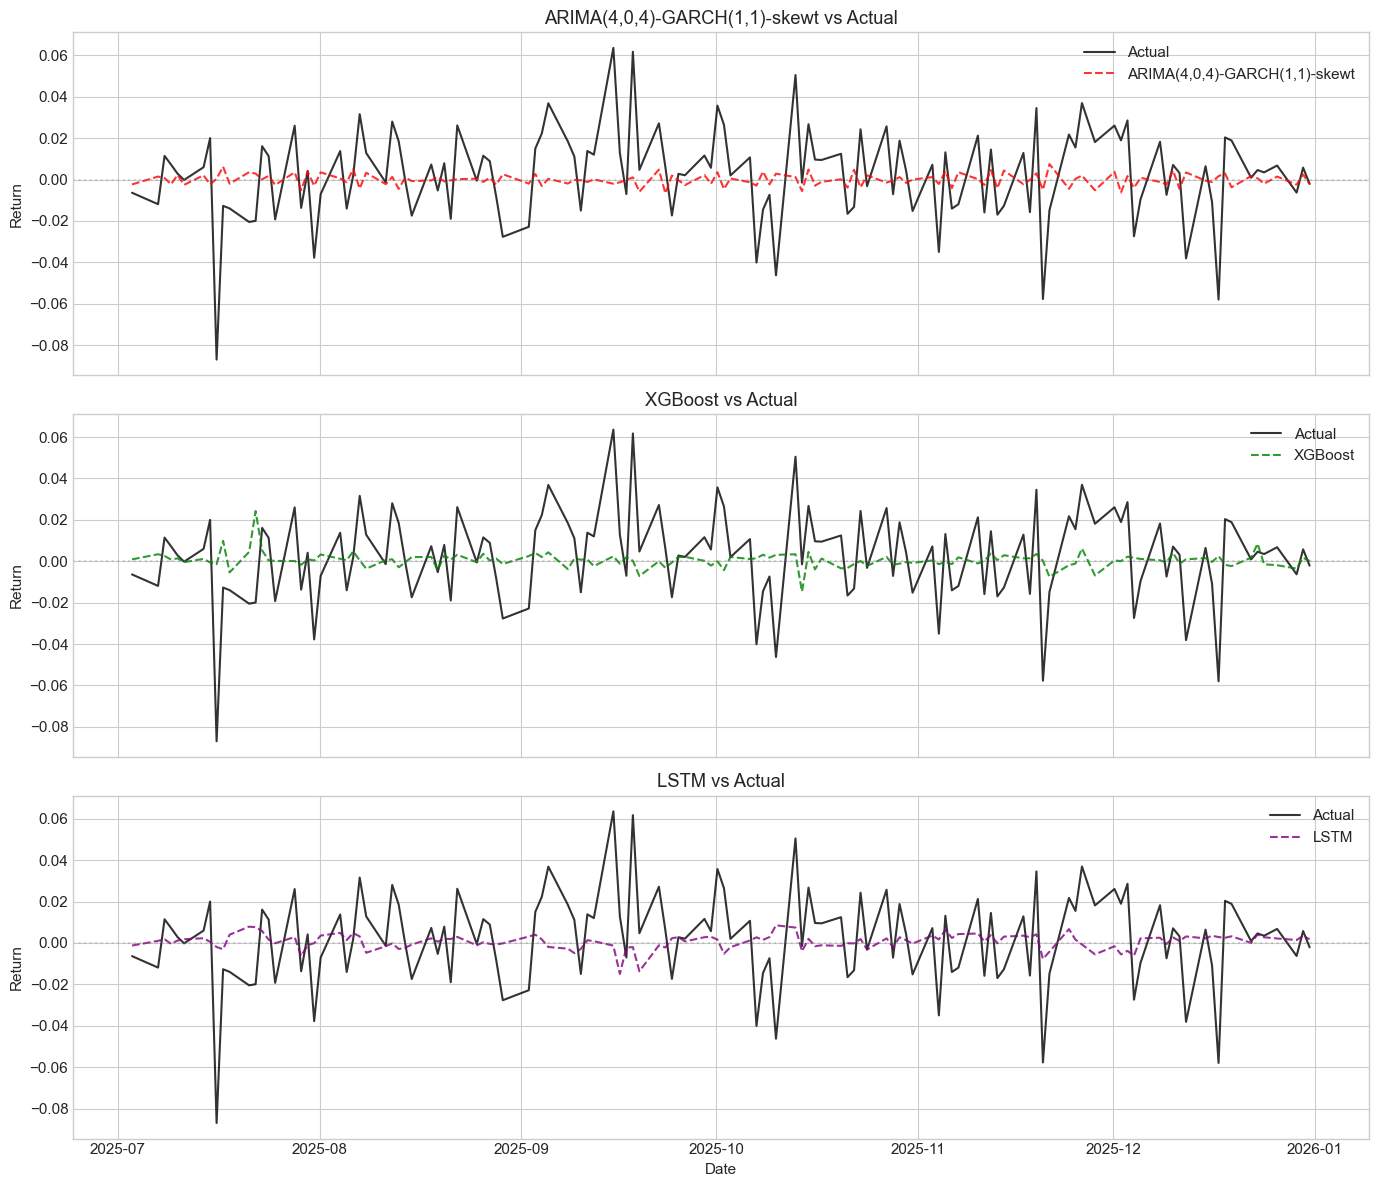

In [230]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
models = ['ARIMA_GARCH_Pred', 'XGB_Pred', 'LSTM_Pred']
titles = [model_name, 'XGBoost', 'LSTM']
colors = ['red', 'green', 'purple']

for ax, m, title, c in zip(axes, models, titles, colors):
    ax.plot(comparison.index, comparison['Actual'], 'k-', label='Actual', alpha=0.8, lw=1.5)
    ax.plot(comparison.index, comparison[m], color=c, ls='--', label=title, alpha=0.8)
    ax.axhline(0, color='gray', ls=':', alpha=0.3)
    ax.set_title(f'{title} vs Actual')
    ax.set_ylabel('Return')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

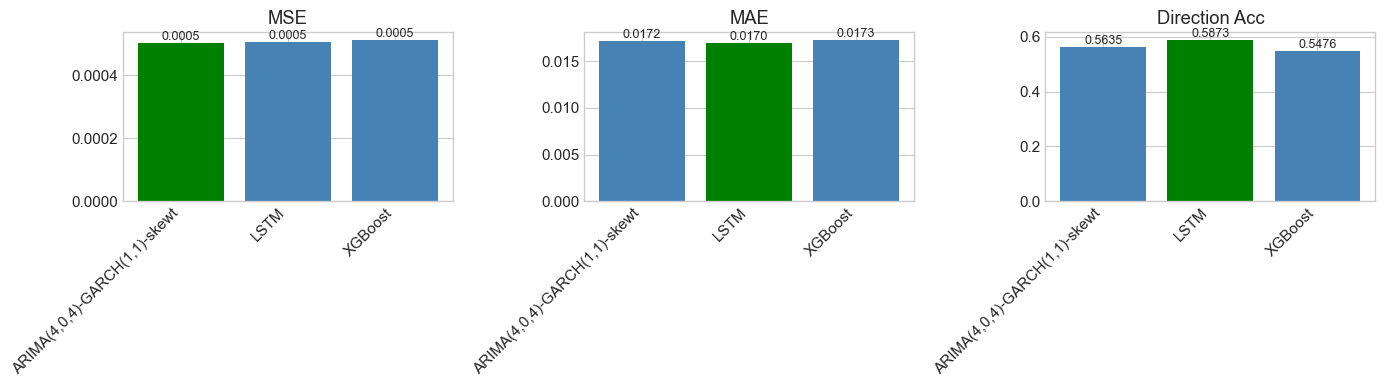

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, metric in enumerate(['MSE', 'MAE', 'Direction Acc']):
    vals = metrics_df[metric].values
    clrs = ['green' if v == (vals.max() if metric == 'Direction Acc' else vals.min()) else 'steelblue' for v in vals]
    axes[i].bar(range(len(metrics_df)), vals, color=clrs)
    axes[i].set_xticks(range(len(metrics_df)))
    axes[i].set_xticklabels(metrics_df.index, rotation=45, ha='right')
    axes[i].set_title(metric)
    for j, v in enumerate(vals):
        axes[i].text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

---
## Final Summary

In [232]:
print("=" * 75)
print(f"FINAL REPORT: {TICKER}")
print("=" * 75)
print(f"\nData: {START_DATE} to {END_DATE} ({len(df)} obs)")
print(f"Backtest: Last {TEST_SIZE} days (walk-forward, expanding window)")
print(f"\nARIMA-GARCH Selection (Two-Step):")
print(f"  Series: {'Log Returns' if USE_SERIES == 'log_returns' else 'Differenced Price'}")
print(f"  ARIMA Grid: p∈[0,{MAX_AR}], d={SERIES_D}, q∈[0,{MAX_MA}]")
print(f"  Best ARIMA: ({BEST_P},{BEST_D},{BEST_Q})")
print(f"  GARCH: (1,1) with {BEST_DIST} innovations")
print(f"\n{'Model':<40} {'MSE':<12} {'MAE':<12} {'Dir Acc':<12}")
print("-" * 76)
for m, row in metrics_df.iterrows():
    print(f"{m:<40} {row['MSE']:<12.6f} {row['MAE']:<12.6f} {row['Direction Acc']:<12.2%}")
print("-" * 76)
print(f"\n✓ Winner (MSE):       {metrics_df.index[0]}")
print(f"✓ Winner (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")

FINAL REPORT: ASML

Data: 2012-01-01 to 2025-12-31 (2513 obs)
Backtest: Last 126 days (walk-forward, expanding window)

ARIMA-GARCH Selection (Two-Step):
  Series: Log Returns
  ARIMA Grid: p∈[0,4], d=0, q∈[0,4]
  Best ARIMA: (4,0,4)
  GARCH: (1,1) with skewt innovations

Model                                    MSE          MAE          Dir Acc     
----------------------------------------------------------------------------
ARIMA(4,0,4)-GARCH(1,1)-skewt            0.000502     0.017189     56.35%      
LSTM                                     0.000506     0.016990     58.73%      
XGBoost                                  0.000510     0.017256     54.76%      
----------------------------------------------------------------------------

✓ Winner (MSE):       ARIMA(4,0,4)-GARCH(1,1)-skewt
✓ Winner (Direction): LSTM


# Conclusions and Limitations

Key findings:
- ARIMA models explain limited mean dependence in returns
- GARCH models successfully remove variance autocorrelation
- Residual serial dependence persists due to regime shifts and nonlinear dynamics
- Machine learning models do not consistently outperform benchmarks

This outcome is expected and reflects market efficiency rather than model failure.
The project emphasises explanation and robustness over overfitting and getting the 'best model' for predcictability.